In [ ]:
#Tensorflow version 1.x

In [ ]:
%tensorflow_version 1.x
import tensorflow
tensorflow.__version__

!pip uninstall h5py
!pip install h5py==2.10.0

TensorFlow 1.x selected.
Uninstalling h5py-2.10.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h5py-2.10.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h5py/*
Proceed (y/n)? n


Process Data


In [ ]:
!pip install memory_profiler

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
import zipfile
with zipfile.ZipFile('/content/UCI HAR Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('')

--2021-06-09 07:42:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip.1’

UCI HAR Dataset.zip 100%[===================>]  58.17M  64.6MB/s    in 0.9s    

2021-06-09 07:42:48 (64.6 MB/s) - ‘UCI HAR Dataset.zip.1’ saved [60999314/60999314]



In [ ]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

'''
See paper:  Sensors 2018, 18(4), 1055; https://doi.org/10.3390/s18041055
"Divide and Conquer-Based 1D CNN Human Activity Recognition Using Test Data Sharpening"
by Heeryon Cho & Sang Min Yoon
This code loads and sharpens UCI HAR Dataset data.
UCI HAR Dataset data can be downloaded from:
https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones
Unzipped dataset should be placed inside the '../data/UCI HAR Dataset/' folder.
'''

dir_path = 'UCI HAR Dataset/'


def load_x(train_or_test):
    global dir_path
    if train_or_test is "train":
        x_path = dir_path + 'train/X_train.txt'
       
    elif train_or_test is "test":
        x_path = dir_path + 'test/X_test.txt'
        

    with open(x_path) as f:
        container = f.readlines()
    
    result = []
    for line in container:
        tmp1 = line.split()
        #tmp2 = tmp1.replace('  ', ' ')     # removes inconsistent blank spaces
        #tmp_ary = map(float, tmp1)
        
        result.append(tmp1)

    return np.array(result)


def load_y(train_or_test):
    global dir_path
    if train_or_test is "train":
        y_path = dir_path + 'train/y_train.txt'
    elif train_or_test is "test":
        y_path = dir_path + 'test/y_test.txt'

    with open(y_path) as f:
        container = f.readlines()
  
    result = []
    for line in container:
        num_str = line.strip()
        result.append(int(num_str))
    return np.array(result)


def sharpen(x_test, sigma, alpha):
    r = x_test.shape[0]
    c = x_test.shape[1]
    container = np.empty((r, c))
    print("container shape ",container.shape)
    i = 0
    x_test=x_test.astype(np.float)
    print(x_test.shape)
    for row in x_test:
        test = np.array([row])
        blurred = ndimage.gaussian_filter(test, sigma)
        sharpened = test + alpha * (test - blurred)
        
        container[i] = sharpened
        i = i + 1
    return container

Loading Dynamic Data

In [ ]:

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import numpy as np
import random
from numpy.random import seed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K



'''
See paper:  Sensors 2018, 18(4), 1055; https://doi.org/10.3390/s18041055
"Divide and Conquer-Based 1D CNN Human Activity Recognition Using Test Data Sharpening"
by Heeryon Cho & Sang Min Yoon
This code learns dynamic HAR model given in Figure 10.
(Sensors 2018, 18(4), 1055, page 13 of 24)
'''

# Load all train and test data (* dynamic and static data are mixed.)

X_train_all = load_x("train")   # at this stage, the data includes both dynamic and static HAR data
y_train_all = load_y("train")

X_test_all = load_x("test")
y_test_all = load_y("test")


print(X_train_all.shape)
print(X_test_all.shape)

(7352, 561)
(2947, 561)



+++ DATA STATISTICS +++

train_dynamic shape:  (3285, 561)
test_dynamic shape:  (1387, 561)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 559, 100)          400       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 186, 100)          0         
_________________________________________________________________
flatten (Flatten)            (None, 18600)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 55803     
_________________________________________________________________
dropout (Dropout)            (None, 3)                 0         
Total params: 56,203
Trainable params: 56,203
Non-trainable params: 0
__________

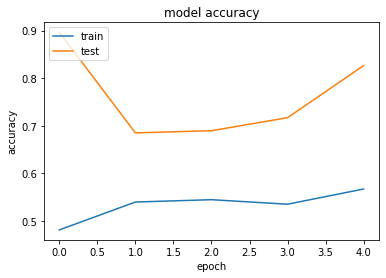

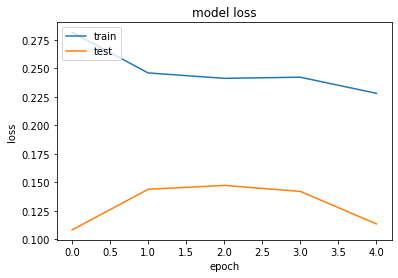

CPU times: user 6.99 s, sys: 981 ms, total: 7.97 s
Wall time: 7.71 s


In [ ]:
%%time
%load_ext memory_profiler

dynamic_1 = np.where(y_train_all == 1)[0]
dynamic_2 = np.where(y_train_all == 2)[0]
dynamic_3 = np.where(y_train_all == 3)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic_list)

X_train = X_train_all[dynamic]
y_train = y_train_all[dynamic]

# Convert (1, 2, 3) labels to (0, 1, 2)
y_train  = y_train - 1

print ("\n+++ DATA STATISTICS +++\n")
print ("train_dynamic shape: ", X_train.shape)

# Select dynamic HAR test data

dynamic_1 = np.where(y_test_all == 1)[0]
dynamic_2 = np.where(y_test_all == 2)[0]
dynamic_3 = np.where(y_test_all == 3)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])

X_test = X_test_all[dynamic]
y_test = y_test_all[dynamic]

# Convert (1, 2, 3) labels to (0, 1, 2)
y_test  = y_test - 1

print ("test_dynamic shape: ", X_test.shape)

n_classes = 3

# Convert to one hot encoding vector
y_train_dynamic_oh = np.eye(n_classes)[y_train]

# Fit 1d CNN for dynamic HAR

seed(2017)
model = Sequential()
model.add(Conv1D(100, 3, input_shape=(561, 1), activation='relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.add(Dropout(0.5))

adam = Adam(lr=0.0004, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

# Summarize layers
print(model.summary())

# Save model image
if not os.path.exists('fig_har_dyna.png'):
    model_file = 'fig_har_dyna.png'
    plot_model(model, to_file=model_file)

new_dir = 'model/'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
#fpath = new_dir + 'weights.{epoch:02d}-{val_acc:.2f}.hdf5'
fpath = new_dir + 'dynamic.hdf5'
cp_cb = ModelCheckpoint(fpath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# To disable learning, the below code - two lines - is commented.
# To enable learning uncomment the below two lines of code.

history=model.fit(np.expand_dims(X_train, axis=2), y_train_dynamic_oh,
          batch_size=32, epochs=150, verbose=2, validation_split=0.2, callbacks=[cp_cb])
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
del model
K.clear_session()


Dynamic Learn model

In [ ]:
import numpy as np
from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras.models import load_model

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'


'''
See paper:  Sensors 2018, 18(4), 1055; https://doi.org/10.3390/s18041055
"Divide and Conquer-Based 1D CNN Human Activity Recognition Using Test Data Sharpening"
by Heeryon Cho & Sang Min Yoon
This code outputs the result of [UCI HAR (Dynamic) : 1D CNN Only (%) : 97.98%]
given in Table 8. (Sensors 2018, 18(4), 1055, page 19 of 24)
The HAR model is saved as model/dynamic.hdf5
'''

# Load all train and test data (* dynamic and static data are mixed.)

X_train_all = load_x("train")   # at this stage, the data includes both dynamic and static HAR data
y_train_all = load_y("train")

X_test_all = load_x("test")
y_test_all = load_y("test")

# --------------------------------------
# Only dynamic HAR data are selected
# --------------------------------------

# Select dynamic HAR train data

dynamic_1 = np.where(y_train_all == 1)[0]
dynamic_2 = np.where(y_train_all == 2)[0]
dynamic_3 = np.where(y_train_all == 3)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])

X_train = X_train_all[dynamic]
y_train = y_train_all[dynamic]

# Convert (1, 2, 3) labels to (0, 1, 2)
y_train  = y_train - 1

print ("\n+++ DATA STATISTICS +++\n")
print ("train_dynamic shape: ", X_train.shape)

# Select dynamic HAR test data

dynamic_1 = np.where(y_test_all == 1)[0]
dynamic_2 = np.where(y_test_all == 2)[0]
dynamic_3 = np.where(y_test_all == 3)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])

X_test = X_test_all[dynamic]
y_test = y_test_all[dynamic]

# Convert (1, 2, 3) labels to (0, 1, 2)
y_test  = y_test - 1

print ("test_dynamic shape: ", X_test.shape)


# Display dynamic model accuracy

print ("\n+++ DYNAMIC MODEL ACCURACY +++\n")

model_path = "model/dynamic.hdf5"
model = load_model(model_path)

pred_train = model.predict(np.expand_dims(X_train, axis=2), batch_size=32)
print ("------ TRAIN ACCURACY ------")
print (accuracy_score(y_train, np.argmax(pred_train, axis=1)))
print (confusion_matrix(y_train, np.argmax(pred_train, axis=1)))
%timeit pred_test = model.predict(np.expand_dims(X_test, axis=2), batch_size=32)
pred_test = model.predict(np.expand_dims(X_test, axis=2), batch_size=32)
print ("------ TEST ACCURACY ------")
print (accuracy_score(y_test, np.argmax(pred_test, axis=1)))
cm=confusion_matrix(y_test, np.argmax(pred_test, axis=1))
print (cm)






+++ DATA STATISTICS +++

train_dynamic shape:  (3285, 561)
test_dynamic shape:  (1387, 561)

+++ DYNAMIC MODEL ACCURACY +++

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
------ TRAIN ACCURACY ------
0.9245053272450533
[[1185   24   17]
 [  33 1009   31]
 [  36  107  843]]
1 loop, best of 5: 307 ms per loop
------ TEST ACCURACY ------
0.882480173035328
[[489   0   7]
 [ 18 449   4]
 [ 87  47 286]]


Static learn model


+++ DATA STATISTICS +++

train_static shape:  (4067, 561)
test_static shape:  (1560, 561)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 559, 30)           120       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 557, 50)           4550      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 555, 100)          15100     
_________________________________________________________________
flatten (Flatten)            (None, 55500)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 166503    
_________________________________________________________________
dropout (Dropout)            (None, 3)                 0         
Total params: 186,273
Trainable

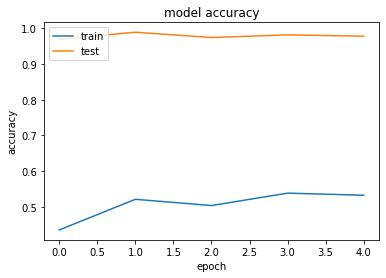

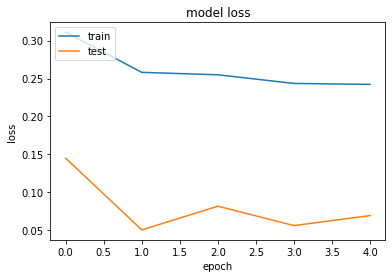

CPU times: user 9.4 s, sys: 591 ms, total: 9.99 s
Wall time: 9.79 s


In [ ]:
%%time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import numpy as np
import random
from numpy.random import seed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt



'''
See paper:  Sensors 2018, 18(4), 1055; https://doi.org/10.3390/s18041055
"Divide and Conquer-Based 1D CNN Human Activity Recognition Using Test Data Sharpening"
by Heeryon Cho & Sang Min Yoon
This code learns dynamic HAR model given in Figure 11.
(Sensors 2018, 18(4), 1055, page 13 of 24)
'''

# Load all train and test data (* dynamic and static data are mixed.)

X_train_all = load_x("train")   # at this stage, the data includes both dynamic and static HAR data
y_train_all = load_y("train")

X_test_all = load_x("test")
y_test_all = load_y("test")

# --------------------------------------
# Only static HAR data are selected
# --------------------------------------

# Select static HAR train data

static_1 = np.where(y_train_all == 4)[0]
static_2 = np.where(y_train_all == 5)[0]
static_3 = np.where(y_train_all == 6)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

# Shuffle static data index
r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static_list)

X_train = X_train_all[static]
y_train = y_train_all[static]

# Convert (4, 5, 6) labels to (0, 1, 2)
y_train  = y_train - 4

print ("\n+++ DATA STATISTICS +++\n")
print ("train_static shape: ", X_train.shape)

# Select static HAR test data

static_1 = np.where(y_test_all == 4)[0]
static_2 = np.where(y_test_all == 5)[0]
static_3 = np.where(y_test_all == 6)[0]
static = np.concatenate([static_1, static_2, static_3])

X_test = X_test_all[static]
y_test = y_test_all[static]

# Convert (4, 5, 6) labels to (0, 1, 2)
y_test  = y_test - 4

print ("test_static shape: ", X_test.shape)

n_classes = 3

# Convert to one hot encoding vector
y_train_static_oh = np.eye(n_classes)[y_train]

# Fit 1d CNN for static HAR

seed(2017)
model = Sequential()
model.add(Conv1D(30, 3, input_shape=(561, 1), activation='relu'))
model.add(Conv1D(50, 3, activation='relu'))
model.add(Conv1D(100, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.add(Dropout(0.50))

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

# Summarize layers
print(model.summary())

if not os.path.exists('fig_har_stat.png'):
    model_file = 'fig_har_stat.png'
    plot_model(model, to_file=model_file)

new_dir = 'model/'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
#fpath = new_dir + 'weights.{epoch:02d}-{val_acc:.2f}.hdf5'
fpath = new_dir + 'static.hdf5'
cp_cb = ModelCheckpoint(fpath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# To disable learning, the below code - two lines - is commented.
# To enable learning uncomment the below two lines of code.

history=model.fit(np.expand_dims(X_train, axis=2), y_train_static_oh,
          batch_size=32, epochs=150 , verbose=2, validation_split=0.2, callbacks=[cp_cb]) #150
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
del model
K.clear_session()















Load Static model

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model


import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'


'''
See paper:  Sensors 2018, 18(4), 1055; https://doi.org/10.3390/s18041055
"Divide and Conquer-Based 1D CNN Human Activity Recognition Using Test Data Sharpening"
by Heeryon Cho & Sang Min Yoon
This code outputs the result of [UCI HAR (Static) : 1D CNN Only (%) : 96.60%]
given in Table 8. (Sensors 2018, 18(4), 1055, page 19 of 24)
The HAR model is saved as model/static.hdf5
'''

# Load all train and test data (* dynamic and static data are mixed.)

X_train_all =load_x("train")   # at this stage, the data includes both dynamic and static HAR data
y_train_all = load_y("train")

X_test_all = load_x("test")
y_test_all = load_y("test")

# --------------------------------------
# Only static HAR data are selected
# --------------------------------------

# Select static HAR train data

static_1 = np.where(y_train_all == 4)[0]
static_2 = np.where(y_train_all == 5)[0]
static_3 = np.where(y_train_all == 6)[0]
static = np.concatenate([static_1, static_2, static_3])

X_train = X_train_all[static]
y_train = y_train_all[static]

# Convert (4, 5, 6) labels to (0, 1, 2)
y_train  = y_train - 4

print ("\n+++ DATA STATISTICS +++\n")
print ("train_static shape: ", X_train.shape)

# Select static HAR test data

static_1 = np.where(y_test_all == 4)[0]
static_2 = np.where(y_test_all == 5)[0]
static_3 = np.where(y_test_all == 6)[0]
static = np.concatenate([static_1, static_2, static_3])

X_test = X_test_all[static]
y_test = y_test_all[static]

# Convert (4, 5, 6) labels to (0, 1, 2)
y_test  = y_test - 4

print ("test_static shape: ", X_test.shape)


# Display static model accuracy

print ("\n+++ STATIC MODEL ACCURACY  +++\n")

model_path = "model/static.hdf5"
model = load_model(model_path)

pred_train = model.predict(np.expand_dims(X_train, axis=2), batch_size=32)
print ("------ TRAIN ACCURACY ------")
print (accuracy_score(y_train, np.argmax(pred_train, axis=1)))
print (confusion_matrix(y_train, np.argmax(pred_train, axis=1)))

pred_test = model.predict(np.expand_dims(X_test, axis=2), batch_size=32)
print ("------ TEST ACCURACY ------")
print (accuracy_score(y_test, np.argmax(pred_test, axis=1)))
print (confusion_matrix(y_test, np.argmax(pred_test, axis=1)))





+++ DATA STATISTICS +++

train_static shape:  (4067, 561)
test_static shape:  (1560, 561)

+++ STATIC MODEL ACCURACY  +++

------ TRAIN ACCURACY ------
0.9164002950577822
[[1015  247   24]
 [  69 1305    0]
 [   0    0 1407]]
------ TEST ACCURACY ------
0.9051282051282051
[[369 117   5]
 [ 26 506   0]
 [  0   0 537]]


Compared with other machine learning models

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


# Load all train and test data (* dynamic and static data are mixed.)

X_train = load_x("train")
y_train =load_y("train")

X_test = load_x("test")
y_test = load_y("test")


print ("==================================")
print (" ACCURACY OF OTHER ML CLASSIFIERS")
print ("==================================")


# Build a logistic regression classifier and predict

#clf_lr = LogisticRegression(random_state=0)
#clf_lr.fit(X_train, y_train)

#pred_lr = clf_lr.predict(X_test)

#print ("\n--- Logistic Regression Classifier ---")
#print (accuracy_score(y_test, pred_lr))
#print (confusion_matrix(y_test, pred_lr))


# Build an SVM classifier and predict

clf_svm = SVC(random_state=0)
clf_svm.fit(X_train, y_train)

pred_svm = clf_svm.predict(X_test)

print ("\n--- SVM Classifier ---")
print (accuracy_score(y_test, pred_svm))
print (confusion_matrix(y_test, pred_svm))




# Build a decision tree classifier and predict

clf_dt = DecisionTreeClassifier(random_state=0)
clf_dt.fit(X_train, y_train)

pred_dt = clf_dt.predict(X_test)

print ("\n--- Decision Tree Classifier ---")
print (accuracy_score(y_test, pred_dt))
print (confusion_matrix(y_test, pred_dt))

 ACCURACY OF OTHER ML CLASSIFIERS

--- SVM Classifier ---
0.9504580929759077
[[488   5   3   0   0   0]
 [ 20 451   0   0   0   0]
 [ 10  26 384   0   0   0]
 [  0   2   0 438  51   0]
 [  0   0   0  29 503   0]
 [  0   0   0   0   0 537]]

--- Decision Tree Classifier ---
0.8595181540549711
[[448  24  24   0   0   0]
 [ 74 367  30   0   0   0]
 [ 23  46 351   0   0   0]
 [  0   0   0 373 118   0]
 [  0   0   0  75 457   0]
 [  0   0   0   0   0 537]]
CPU times: user 19.8 s, sys: 308 ms, total: 20.2 s
Wall time: 20.2 s


Sharpened Static Data

test_static_first shape:  (779, 561)
test_static_second shape:  (781, 561)

=== COMPARE ACCURACY: NO SHARPEN vs. SHARPENED  ===
===         Test Data: First Half         ===

---------------------------------
       NO SHARPEN ACCURACY       
---------------------------------
0.9114249037227214
[[190  51   4]
 [ 14 252   0]
 [  0   0 268]]

---------------------------------
       SHARPENED  ACCURACY       
---------------------------------
container shape  (779, 561)
(779, 561)
>>> sigma=5, alpha=0.01
0.9114249037227214
[[190  51   4]
 [ 14 252   0]
 [  0   0 268]]
container shape  (779, 561)
(779, 561)
>>> sigma=5, alpha=0.02
0.9127086007702182
[[191  50   4]
 [ 14 252   0]
 [  0   0 268]]
container shape  (779, 561)
(779, 561)
>>> sigma=5, alpha=0.03
0.9127086007702182
[[191  50   4]
 [ 14 252   0]
 [  0   0 268]]
container shape  (779, 561)
(779, 561)
>>> sigma=5, alpha=0.04
0.9127086007702182
[[191  50   4]
 [ 14 252   0]
 [  0   0 268]]
container shape  (779, 561)
(779, 561)
>>> 

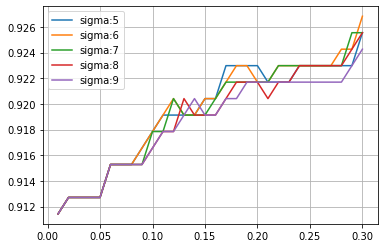

Max accuracy:  0.926829268292683

=== COMPARE ACCURACY: NO SHARPEN vs. SHARPENED  ===
===         Test Data: Second Half         ===

---------------------------------
       NO SHARPEN ACCURACY       
---------------------------------
0.8988476312419974
[[179  66   1]
 [ 12 254   0]
 [  0   0 269]]

---------------------------------
       SHARPENED  ACCURACY       
---------------------------------
container shape  (781, 561)
(781, 561)
>>> sigma=5, alpha=0.01
0.9026888604353394
[[182  63   1]
 [ 12 254   0]
 [  0   0 269]]
container shape  (781, 561)
(781, 561)
>>> sigma=5, alpha=0.02
0.9039692701664532
[[183  62   1]
 [ 12 254   0]
 [  0   0 269]]
container shape  (781, 561)
(781, 561)
>>> sigma=5, alpha=0.03
0.9039692701664532
[[183  62   1]
 [ 12 254   0]
 [  0   0 269]]
container shape  (781, 561)
(781, 561)
>>> sigma=5, alpha=0.04
0.9026888604353394
[[183  62   1]
 [ 13 253   0]
 [  0   0 269]]
container shape  (781, 561)
(781, 561)
>>> sigma=5, alpha=0.05
0.9039692701664532
[[

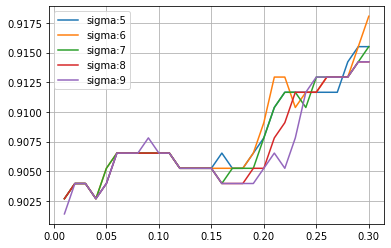

Max accuracy:  0.9180537772087067


In [ ]:

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import random
from tabulate import tabulate

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'


'''
See paper:  Sensors 2018, 18(4), 1055; https://doi.org/10.3390/s18041055
"Divide and Conquer-Based 1D CNN Human Activity Recognition Using Test Data Sharpening"
by Heeryon Cho & Sang Min Yoon
This code outputs the result of [UCI HAR (Static) : 1D CNN + Sharpen (%) : 96.67%]
given in Table 8. (Sensors 2018, 18(4), 1055, page 19 of 24)
The HAR model used is 'model/static.hdf5'.
'''

def display_output(title_str, X, y):

    # Load static HAR model
    model_path = "model/static.hdf5"
    model = load_model(model_path)

    print ("\n=== COMPARE ACCURACY: NO SHARPEN vs. SHARPENED  ===")
    print ("===         Test Data: {} Half         ===\n".format(title_str))

    pred_dyna_raw = model.predict(np.expand_dims(X, axis=2), batch_size=32)
    print ("---------------------------------")
    print ("       NO SHARPEN ACCURACY       ")
    print ("---------------------------------")
    print (accuracy_score(y, np.argmax(pred_dyna_raw, axis=1)))
    print (confusion_matrix(y, np.argmax(pred_dyna_raw, axis=1)))

    print ("\n---------------------------------")
    print ("       SHARPENED  ACCURACY       ")
    print ("---------------------------------")

    alpha = np.arange(0.01, 0.31, 0.01)
    sigma = np.arange(5, 10, 1)
    plt.figure()
    max_acc=[]
    for s in sigma:
        acc=[]
        for a in alpha:
            # Sharpen test data with various sigma (for Gaussian filter) and alpha value combinations
            X_test_sharpen = sharpen(X, s, a)
            pred_dyna_sharpen = model.predict(np.expand_dims(X_test_sharpen, axis=2), batch_size=32)
            accuracy=accuracy_score(y, np.argmax(pred_dyna_sharpen, axis=1))
            acc.append(accuracy)
            max_acc.append(accuracy)
            print (">>> sigma={}, alpha={:.2f}".format(s, a))
            print (accuracy)
            print (confusion_matrix(y, np.argmax(pred_dyna_sharpen, axis=1)))
        plt.plot(alpha,acc,label='sigma:{}'.format(s))
        plt.legend()
        
    plt.grid(b=None, which='major', axis='both')
    plt.show()
    print("Max accuracy: ", max(max_acc))

# Load all test data (* dynamic and static data are mixed.)

X_test = load_x("test")
y_test = load_y("test")

# Set seed to ensure reproducibility of the paper.

seed = 818

# Static (4-sitting, 5-standing, 6-laying) test data are selected and
# split it in two, first & second, in order to determine
# sigma & alpha values for test data sharpening.

random.seed(seed)
stat_1 = np.where(y_test == 4)[0]
stat_1_first = random.sample(list(stat_1), int(len(stat_1) * 0.5))
stat_1_second = list(set(stat_1) - set(stat_1_first))

random.seed(seed)
stat_2 = np.where(y_test == 5)[0]
stat_2_first = random.sample(list(stat_2), int(len(stat_2) * 0.5))
stat_2_second = list(set(stat_2) - set(stat_2_first))

random.seed(seed)
stat_3 = np.where(y_test == 6)[0]
stat_3_first = random.sample(list(stat_3), int(len(stat_3) * 0.5))
stat_3_second = list(set(stat_3) - set(stat_3_first))

static_first = np.concatenate([stat_1_first, stat_2_first, stat_3_first])
static_second = np.concatenate([stat_1_second, stat_2_second, stat_3_second])

X_test_first = X_test[static_first]
y_test_first = y_test[static_first] - 4   # Convert (4, 5, 6) labels to (0, 1, 2)
print ("test_static_first shape: ", X_test_first.shape)

X_test_second = X_test[static_second]
y_test_second = y_test[static_second] - 4   # Convert (4, 5, 6) labels to (0, 1, 2)
print ("test_static_second shape: ", X_test_second.shape)


# Compare the static model accuracy:
# No sharpened (raw) test data vs. sharpened test data

display_output("First", X_test_first, y_test_first)
display_output("Second", X_test_second, y_test_second)


Sharpened Dynamic Data

test_dynamic_first shape:  (693, 561)
test_dynamic_second shape:  (694, 561)

=== COMPARE ACCURACY: NO SHARPEN vs. SHARPENED  ===
===         Test Data: First Half         ===

---------------------------------
       NO SHARPEN ACCURACY       
---------------------------------
0.8845598845598845
[[244   0   4]
 [  6 227   2]
 [ 45  23 142]]

---------------------------------
       SHARPENED  ACCURACY       
---------------------------------
container shape  (693, 561)
(693, 561)
>>> sigma=5, alpha=0.05
0.8932178932178932
[[244   0   4]
 [  6 227   2]
 [ 39  23 148]]
container shape  (693, 561)
(693, 561)
>>> sigma=5, alpha=0.10
0.8975468975468975
[[244   0   4]
 [  6 227   2]
 [ 37  22 151]]
container shape  (693, 561)
(693, 561)
>>> sigma=5, alpha=0.15
0.898989898989899
[[244   0   4]
 [  6 227   2]
 [ 36  22 152]]
container shape  (693, 561)
(693, 561)
>>> sigma=5, alpha=0.20
0.898989898989899
[[243   0   5]
 [  5 228   2]
 [ 36  22 152]]
container shape  (693, 561)
(693, 561)
>>> 

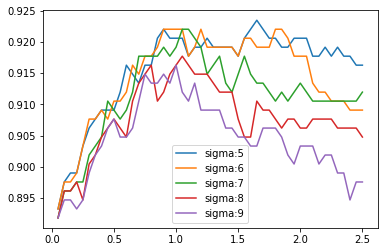


=== COMPARE ACCURACY: NO SHARPEN vs. SHARPENED  ===
===         Test Data: Second Half         ===

---------------------------------
       NO SHARPEN ACCURACY       
---------------------------------
0.8804034582132565
[[245   0   3]
 [ 12 222   2]
 [ 42  24 144]]

---------------------------------
       SHARPENED  ACCURACY       
---------------------------------
container shape  (694, 561)
(694, 561)
>>> sigma=5, alpha=0.05
0.8818443804034583
[[244   0   4]
 [ 12 221   3]
 [ 39  24 147]]
container shape  (694, 561)
(694, 561)
>>> sigma=5, alpha=0.10
0.8847262247838616
[[244   0   4]
 [ 12 221   3]
 [ 38  23 149]]
container shape  (694, 561)
(694, 561)
>>> sigma=5, alpha=0.15
0.8876080691642652
[[244   0   4]
 [ 13 219   4]
 [ 35  22 153]]
container shape  (694, 561)
(694, 561)
>>> sigma=5, alpha=0.20
0.8919308357348703
[[244   0   4]
 [ 13 219   4]
 [ 33  21 156]]
container shape  (694, 561)
(694, 561)
>>> sigma=5, alpha=0.25
0.8948126801152738
[[244   0   4]
 [ 12 219   5]
 [ 33

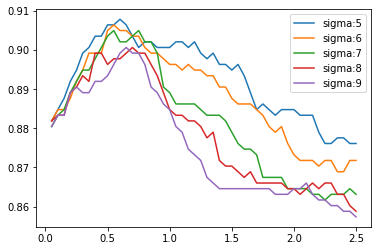

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import random
import pandas as pd


import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'


'''
See paper:  Sensors 2018, 18(4), 1055; https://doi.org/10.3390/s18041055
"Divide and Conquer-Based 1D CNN Human Activity Recognition Using Test Data Sharpening"
by Heeryon Cho & Sang Min Yoon
This code outputs the result of [UCI HAR (Dynamic) : 1D CNN + Sharpen (%) : 98.70%]
given in Table 8. (Sensors 2018, 18(4), 1055, page 19 of 24)
The HAR model used is 'model/dynamic.hdf5'.
'''

def display_output(title_str, X, y):

    # Load dynamic HAR model
    model_path = "model/dynamic.hdf5"
    model = load_model(model_path)

    print ("\n=== COMPARE ACCURACY: NO SHARPEN vs. SHARPENED  ===")
    print ("===         Test Data: {} Half         ===\n".format(title_str))

    pred_dyna_raw = model.predict(np.expand_dims(X, axis=2), batch_size=32)
    print ("---------------------------------")
    print ("       NO SHARPEN ACCURACY       ")
    print ("---------------------------------")
    print (accuracy_score(y, np.argmax(pred_dyna_raw, axis=1)))
    print (confusion_matrix(y, np.argmax(pred_dyna_raw, axis=1)))

    print ("\n---------------------------------")

    print ("       SHARPENED  ACCURACY       ")
    print ("---------------------------------")

    alpha = np.arange(0.05, 2.55, 0.05)
    sigma = np.arange(5, 10, 1)
    plt.figure()
    
    for s in sigma:
        acc=[]
        for a in alpha:
            # Sharpen test data with various sigma (for Gaussian filter) and alpha value combinations
            X_test_sharpen = sharpen(X, s, a)
            pred_dyna_sharpen = model.predict(np.expand_dims(X_test_sharpen, axis=2), batch_size=32)
            print (">>> sigma={}, alpha={:.2f}".format(s, a))
            accuracy=(accuracy_score(y, np.argmax(pred_dyna_sharpen, axis=1)))
            acc.append(accuracy)
            print (accuracy)
            print (confusion_matrix(y, np.argmax(pred_dyna_sharpen, axis=1)))

        plt.plot(alpha,acc,label='sigma:{}'.format(s))
        plt.legend()
    
    plt.show()
    
   
# Load all test data (* dynamic and static data are mixed.)

X_test = load_x("test")
y_test =load_y("test")

# Set seed to ensure reproducibility of the paper.

seed = 2017

# Dynamic (1-walk, 2-WU, 3-WD) test data are selected and
# split it in two, first & second, in order to determine
# sigma & alpha values for test data sharpening.

random.seed(seed)
dyna_1 = np.where(y_test == 1)[0]
dyna_1_first = random.sample(list(dyna_1), int(len(dyna_1) * 0.5))
dyna_1_second = list(set(dyna_1) - set(dyna_1_first))

random.seed(seed)
dyna_2 = np.where(y_test == 2)[0]
dyna_2_first = random.sample(list(dyna_2), int(len(dyna_2) * 0.5))
dyna_2_second = list(set(dyna_2) - set(dyna_2_first))

random.seed(seed)
dyna_3 = np.where(y_test == 3)[0]
dyna_3_first = random.sample(list(dyna_3), int(len(dyna_3) * 0.5))
dyna_3_second = list(set(dyna_3) - set(dyna_3_first))

dynamic_first = np.concatenate([dyna_1_first, dyna_2_first, dyna_3_first])
dynamic_second = np.concatenate([dyna_1_second, dyna_2_second, dyna_3_second])

X_test_first = X_test[dynamic_first]
y_test_first = y_test[dynamic_first] - 1   # Convert (1, 2, 3) labels to (0, 1, 2)
print ("test_dynamic_first shape: ", X_test_first.shape)

X_test_second = X_test[dynamic_second]
y_test_second = y_test[dynamic_second] - 1   # Convert (1, 2, 3) labels to (0, 1, 2)
print ("test_dynamic_second shape: ", X_test_second.shape)


# Compare the dynamic model accuracy:
# No sharpened (raw) test data vs. sharpened test data

display_output("First", X_test_first, y_test_first)
display_output("Second", X_test_second, y_test_second)